# CASA0007 QM Coursework 3

In [102]:
# Import library

import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Regression 1: Well-being scores against NDVI

In [67]:
# Read well-being
wellbeing = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'personal-well-being-borough.xlsx'),
                         sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
cols = ['Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety']
wellbeing.rename({'2018/19': cols[0],
                 '2018/19.1': cols[1],
                 '2018/19.2': cols[2],
                 '2018/19.3': cols[3]},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + cols]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)

# Set data type
wellbeing[cols] = wellbeing[cols].astype('float', copy = False)


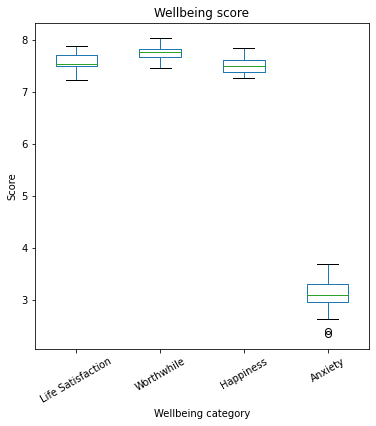

In [78]:
plt.figure(figsize=(6, 6))
plt.title('Wellbeing score')
plt.xlabel('Wellbeing category')
plt.ylabel('Score')
plt1 = wellbeing.boxplot(['Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety'], 
                  grid = False, rot = 30, widths = 0.5)


Read in independent variables - NDVI, self-reported health, age. Other variables added in to control for them, based on study done by ONS (these are those with at least moderate effect on well-being score) and availability of data

In [176]:
# Read NDVI
ndvi = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'green_cover_borough_summary_0.05.xlsx'),
                         sheet_name = 'borough_green_cover')

# Rename and keep useful columns
ndvi = ndvi[['lb_code', 'lb_name', 'percent_green']]

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

In [177]:
ndvi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lb_code        32 non-null     object 
 1   lb_name        32 non-null     object 
 2   percent_green  32 non-null     float64
dtypes: float64(1), object(2)
memory usage: 896.0+ bytes


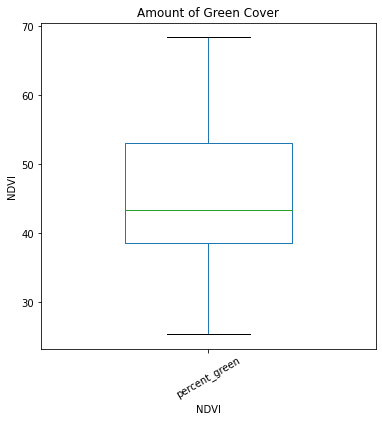

In [81]:
plt.figure(figsize=(6, 6))
plt.title('Amount of Green Cover')
plt.xlabel('NDVI')
plt.ylabel('NDVI')
plt1 = ndvi.boxplot(['percent_green'], 
                  grid = False, rot = 30, widths = 0.5)

In [172]:
# Read self-reported health and age profile
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'msoa-data.csv'),
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health['MSOA Name'][i] = age_health['MSOA Name'][i][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Very_good',
               health_cols[1]: 'Good',
               health_cols[2]: 'Fair',
               health_cols[3]: 'Bad',
               health_cols[4]: 'Very_bad'},
              axis = 1, inplace = True)

/tmp/ipykernel_77/3285840495.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_health['MSOA Name'][i] = age_health['MSOA Name'][i][:-4]


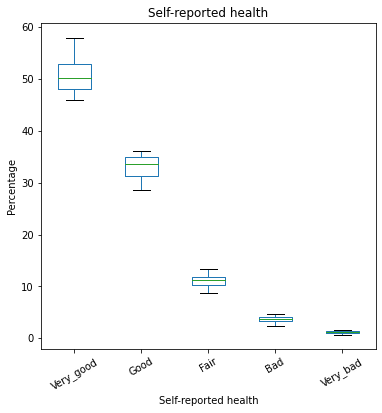

In [83]:
plt.figure(figsize=(6, 6))
plt.title('Self-reported health')
plt.xlabel('Self-reported health')
plt.ylabel('Percentage')
plt1 = health.boxplot(['Very_good', 'Good', 'Fair', 'Bad', 'Very_bad'], 
                  grid = False, rot = 30, widths = 0.5)

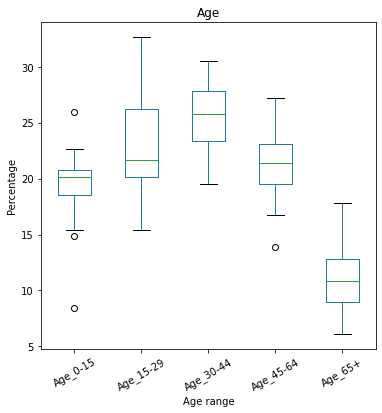

In [86]:
plt.figure(figsize=(6, 6))
plt.title('Age')
plt.xlabel('Age range')
plt.ylabel('Percentage')
plt1 = age.boxplot(['Age_0-15', 'Age_15-29', 'Age_30-44', 'Age_45-64', 'Age_65+'], 
                  grid = False, rot = 30, widths = 0.5)

### Regressions

In [183]:
# Merge independent variables
ind_var = pd.merge(health, age, on = 'MSOA Name')
ind_var = ind_var.merge(ndvi, left_on = 'MSOA Name', right_on = 'lb_code')
ind_var.drop(['lb_code','lb_name'], axis = 1, inplace = True)

In [101]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [196]:
# Define function to perform backwards regression using P-VALUE as selection criterion

def back_regress_p(df_dep, df_ind, thresh=0.05):
    '''
    Performs regression with backwards selection of variables using AIC as selection criterion.

    :param df_dep, df_ind: the pandas dataframe containing dependent variable and indepdendent variables respectively.
    :return: the final regression model
    '''    
    
    print('P-VALUE')
    
    # Initialize index_to_drop
    index_to_drop = []
    
    while True:
        # Get variables
        var = df_ind.columns.values.tolist()
        
        # Perform regressions
        if index_to_drop == 'const':
            reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
        else:
            reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
        
        # Find p-values for all variables
        df_pval = reg_model.pvalues
        #df_pval = pd.Series([reg_model.pvalues[i] for i in var], name='pvalue', index = var).to_frame()
        
        # If best (lowest) new AIC is lower than the current best, remove variable that improves AIC the most
        if df_pval.max() > thresh:
            # If there are multiple variables with best new AIC, choose the first one
            index_to_drop = df_pval.index[df_pval == df_pval.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            # Drop variable from df_ind
            if index_to_drop != 'const':
                df_ind = df_ind.drop(columns = index_to_drop)
        else:
            break
            
    # Perform regression with final set of variables
    if index_to_drop == 'const':
        reg_model = sm.OLS(endog=df_dep, exog=df_ind).fit()
    else:
        reg_model = sm.OLS(endog=df_dep, exog=sm.add_constant(df_ind)).fit()
    
    return reg_model

In [197]:
# Drop collinear independent variables
ind_var_clean = drop_column_using_vif_(ind_var.drop('MSOA Name', axis=1))

Dropping: Very_good
Dropping: Age_0-15
Dropping: Bad
Dropping: Age_45-64
Dropping: Fair
Dropping: Age_65+


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


PERFORMING REGRESSION ON:Life satisfaction
P-VALUE
Dropping: percent_green
Dropping: Age_30-44
Dropping: Age_15-29
Dropping: Good
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.262
Date:                Sat, 01 Jan 2022   Prob (F-statistic):             0.0477
Time:                        16:33:07   Log-Likelihood:                 13.622
No. Observations:                  32   AIC:                            -23.24
Df Residuals:                      30   BIC:                            -20.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

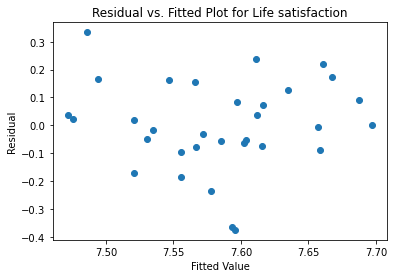



PERFORMING REGRESSION ON:Worthwhile
P-VALUE
Dropping: Age_15-29
Dropping: Age_30-44
Dropping: percent_green
Dropping: Very_bad
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     12.15
Date:                Sat, 01 Jan 2022   Prob (F-statistic):            0.00153
Time:                        16:33:07   Log-Likelihood:                 23.354
No. Observations:                  32   AIC:                            -42.71
Df Residuals:                      30   BIC:                            -39.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

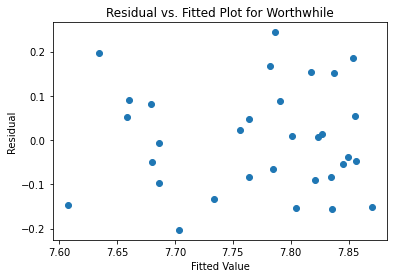



PERFORMING REGRESSION ON:Happiness
P-VALUE
Dropping: Age_15-29
Dropping: Age_30-44
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     5.775
Date:                Sat, 01 Jan 2022   Prob (F-statistic):            0.00332
Time:                        16:33:07   Log-Likelihood:                 21.103
No. Observations:                  32   AIC:                            -34.21
Df Residuals:                      28   BIC:                            -28.34
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

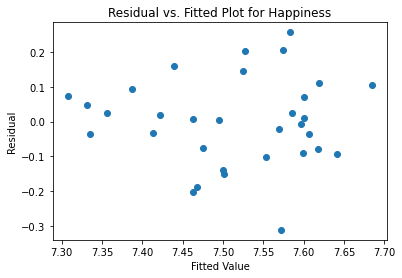

In [198]:
wellbeing_cat = ['Life Satisfaction', 'Worthwhile', 'Happiness']

# Perform regression
for cat in wellbeing_cat:
    print(f'PERFORMING REGRESSION ON:{cat.capitalize()}')
    
    # Perform regression
    reg_model = back_regress_p(wellbeing[cat], ind_var_clean)
    #reg_model = sm.OLS(endog=wellbeing[cat], exog=sm.add_constant(ind_var_clean)).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.capitalize())
    plt.show()
    print('\n')
    

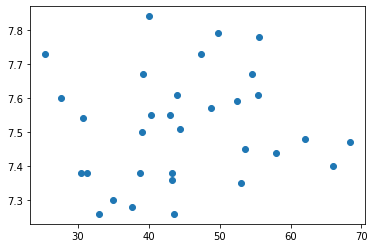

In [193]:
plt.scatter(ind_var.percent_green, wellbeing['Happiness'])

In [186]:
wellbeing

,Code,Area,Life Satisfaction,Worthwhile,Happiness,Anxiety
0,E09000002,Barking and Dagenham,7.52,7.88,7.67,2.82
1,E09000003,Barnet,7.55,7.68,7.44,3.19
2,E09000004,Bexley,7.54,7.83,7.55,3.21
3,E09000005,Brent,7.71,7.84,7.84,2.40
4,E09000006,Bromley,7.57,7.65,7.47,2.88
5,E09000007,Camden,7.48,7.63,7.38,3.30
6,E09000008,Croydon,7.69,7.81,7.78,2.93
7,E09000009,Ealing,7.53,7.97,7.61,3.40
8,E09000010,Enfield,7.37,7.68,7.35,2.96
9,E09000011,Greenwich,7.54,7.81,7.36,2.98


In [179]:
wellbeing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Code               32 non-null     object 
 1   Area               32 non-null     object 
 2   Life Satisfaction  32 non-null     float64
 3   Worthwhile         32 non-null     float64
 4   Happiness          32 non-null     float64
 5   Anxiety            32 non-null     float64
dtypes: float64(4), object(2)
memory usage: 1.6+ KB


## Placeholder

In [66]:
# Read economic inactivity and rename columns for easy reference
econ_cols = ['Code', 'Area', 'percent; Jan 2018-Dec 2018']
economic = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'economic-inactivity.csv'),
                         usecols = econ_cols, 
                         low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Econ_inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)
economic.Econ_inactive = economic.Econ_inactive.astype('float', copy = False)

In [ ]:
# Read employment data
employ = pd.read_excel(os.path.join(os.getcwd(), 'Data', 'employment-by-occ-and-gender.xlsx'),
                       sheet_name = '2018', header = [0, 1])

# Keep only data on London boroughs (Area Code starts with E09)
employ.dropna(axis = 0, inplace = True)
employ = employ[employ['Unnamed: 0_level_0']['Code'].str.match(r'E09')]
employ.drop(employ[employ['Unnamed: 1_level_0']['Area'] == 'City of London'].index, inplace = True)
employ = employ.reset_index(drop = True)

# Create labels for the occupation types
occ = ['managers, directors and senior officials',
      'professional occupations',
      'associate prof & tech occupations',
      'administrative and secretarial occupations',
      'skilled trades occupations',
      'caring, leisure and other service occupations',
      'sales and customer service occupations',
      'process, plant and machine operatives',
      'elementary occupations']

# Compute percentage of economically active and total number of respondents as temp column
economic['Econ_active'] = 100 - economic['Econ_inactive']
economic['respondents'] = employ['% males in employment who are - 1: ' + occ[0] + ' (SOC2010)']['denominator'] + (
    employ['% females in employment who are - 1: ' + occ[0] + ' (SOC2010)']['denominator'])

# Compute number of economically active in each occupation type
for i in range(0, len(occ)):
    print(str(i+1))
    # Number of economically active
    economic[occ[i]] = employ['% males in employment who are - ' + str(i+1) + ': ' + occ[i] + ' (SOC2010)']['numerator'] + (
        employ['% females in employment who are - ' + str(i+1) + ': ' + occ[i] + ' (SOC2010)']['numerator'])
    # Percentage in each occupation type
    economic[occ[i]] = economic[occ[i]].div(economic['respondents'], axis = 0)
    economic[occ[i]] = economic[occ[i]] * economic.Econ_active


In [65]:
economic

,Code,Area,Econ_inactive,Econ_active,respondents,"managers, directors and senior officials",professional occupations,associate prof & tech occupations,administrative and secretarial occupations
0,E09000002,Barking and Dagenham,27.0,73.0,95300.0,5.132214,11.643232,8.579224,9.192025
1,E09000003,Barnet,24.0,76.0,192300.0,11.856474,22.171607,11.145086,10.354654
2,E09000004,Bexley,21.0,79.0,123800.0,7.84895,17.548465,15.123586,9.890953
3,E09000005,Brent,25.0,75.0,160900.0,5.640149,14.216905,10.441268,5.779988
4,E09000006,Bromley,18.0,82.0,163500.0,7.924159,22.719266,16.500306,8.776758
5,E09000007,Camden,24.0,76.0,138200.0,13.52822,22.986975,17.322721,4.564399
6,E09000008,Croydon,21.0,79.0,200800.0,8.694721,21.008964,10.111056,9.717629
7,E09000009,Ealing,21.0,79.0,171200.0,9.644276,18.873248,17.165888,6.55257
8,E09000010,Enfield,27.0,73.0,156900.0,6.188018,18.191842,11.492033,8.607393
9,E09000011,Greenwich,24.0,76.0,142000.0,8.402817,21.729577,15.307042,5.673239
